# **Задача регрессии**
**Forest Fires**

**Abstract: This is a difficult regression task, where the aim is to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data**

https://archive.ics.uci.edu/ml/datasets/Forest+Fires

**Attribute Information:**

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9 
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9 
3. month - month of the year: 'jan' to 'dec' 
4. day - day of the week: 'mon' to 'sun' 
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20 
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10 
9. temp - temperature in Celsius degrees: 2.2 to 33.30 
10. RH - relative humidity in %: 15.0 to 100 
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 
(this output variable is very skewed towards 0.0, thus it may make 
sense to model with the logarithm transform)

In [356]:
# ! pip install lightgbm
# ! pip install --upgrade catboost==0.25

In [357]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [358]:
data = pd.read_table('forestfires.csv', sep=',')
data.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# EDA & Preprocessing

In [359]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [360]:
data.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [361]:
data.month.unique()

array(['mar', 'oct', 'aug', 'sep', 'apr', 'jun', 'jul', 'feb', 'jan',
       'dec', 'may', 'nov'], dtype=object)

In [362]:
data.day.unique()

array(['fri', 'tue', 'sat', 'sun', 'mon', 'wed', 'thu'], dtype=object)

Посмотрим на корреляцию признаков

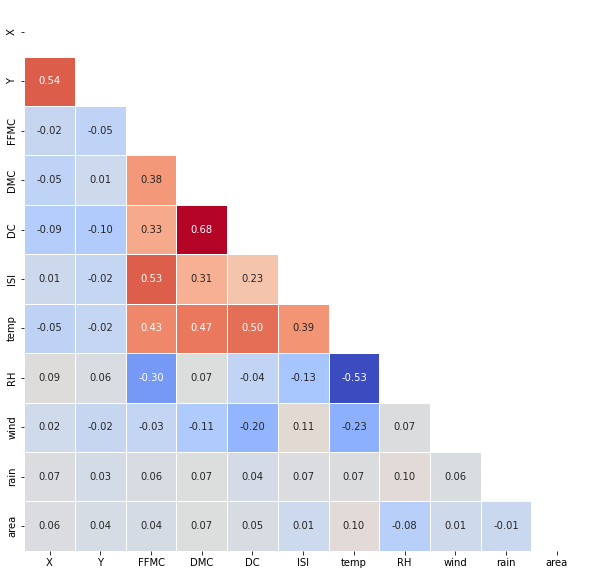

In [363]:
plt.figure(figsize=(10, 10))
mask = np.triu(data.corr())
sns.heatmap(data.corr(), annot=True, cbar=False, linewidths=.5, fmt= '.2f', cmap= 'coolwarm', mask=mask)
plt.show()

array([[<Axes: title={'center': 'X'}>, <Axes: title={'center': 'Y'}>,
        <Axes: title={'center': 'FFMC'}>],
       [<Axes: title={'center': 'DMC'}>, <Axes: title={'center': 'DC'}>,
        <Axes: title={'center': 'ISI'}>],
       [<Axes: title={'center': 'temp'}>, <Axes: title={'center': 'RH'}>,
        <Axes: title={'center': 'wind'}>],
       [<Axes: title={'center': 'rain'}>,
        <Axes: title={'center': 'area'}>, <Axes: >]], dtype=object)

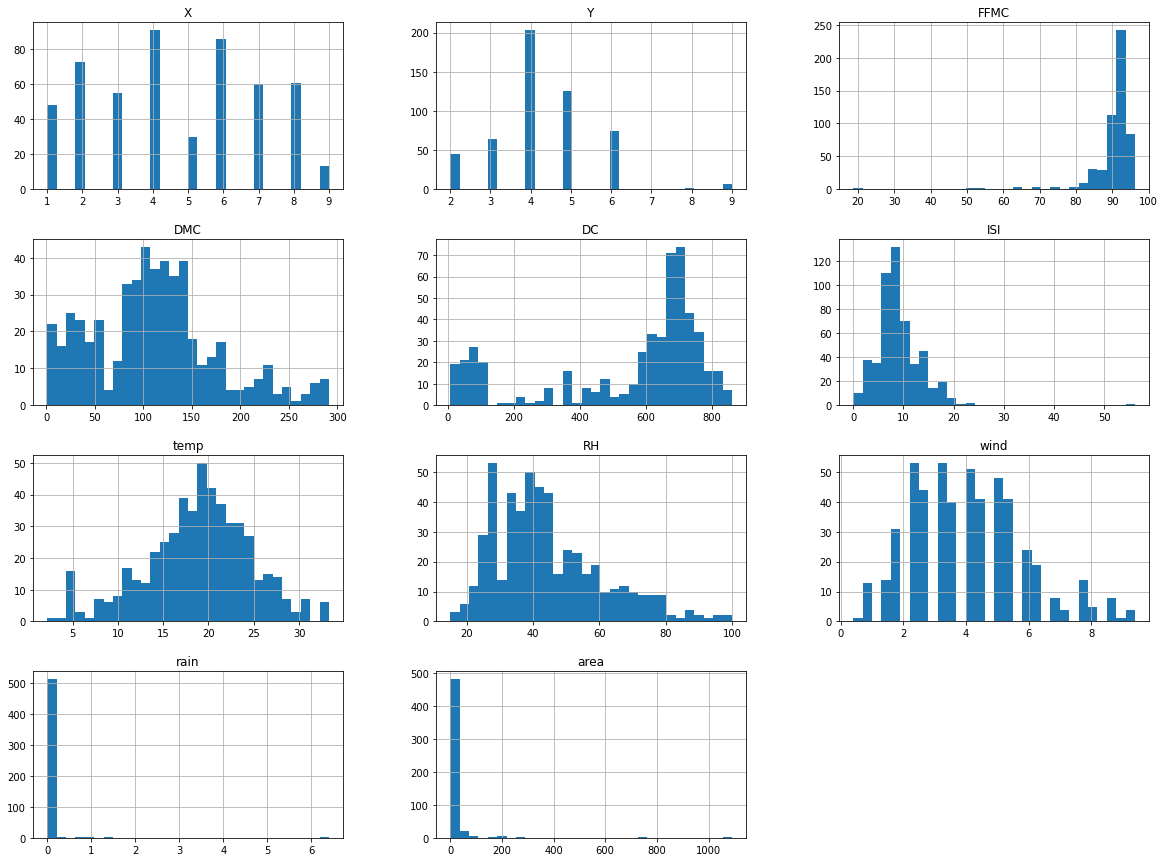

In [364]:
data.hist(bins=30, figsize=(20,15))

Посмотрим на выбросы

<Axes: >

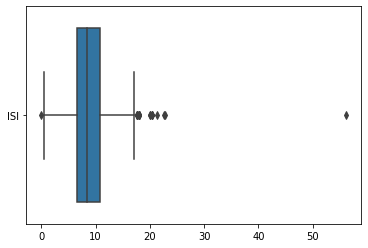

In [365]:
sns.boxplot(data[['ISI']], orient='horizont')

<Axes: >

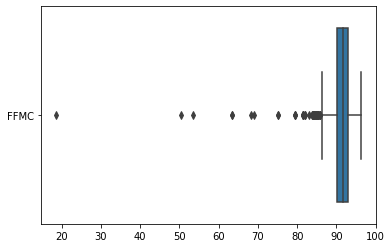

In [366]:
sns.boxplot(data[['FFMC']], orient='horizont')

<Axes: >

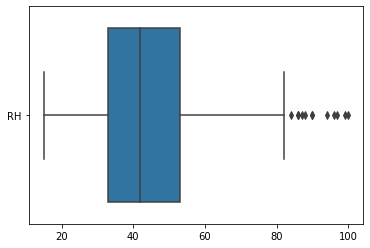

In [367]:
sns.boxplot(data[['RH']], orient='horizont')

<Axes: >

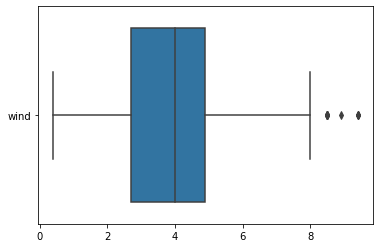

In [368]:
sns.boxplot(data[['wind']], orient='horizont')

<Axes: >

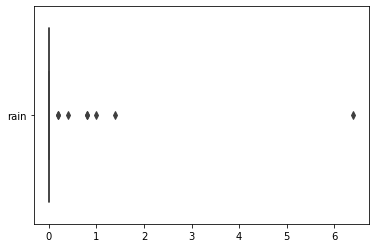

In [369]:
sns.boxplot(data[['rain']], orient='horizont')

Я не уверен что это выбросы, так как если смотреть на природу данных, то диапазон изменения ветра похож на истину, температура тоже в диапазоне возможных значений, мм. осадков тоже похоже на истину. Не буду я удалять выбросы, так они не являются выбросами.

Закодируем категориальные признаки в dummies переменные

In [370]:
data = pd.get_dummies(data, columns=['day', 'month'], prefix_sep='=')

In [371]:
# data.head(3)

Либо используем LabelEncoder

In [372]:
# le = LabelEncoder()
# data['day'] = le.fit_transform(data['day'])
# data['month'] = le.fit_transform(data['month'])

In [373]:
data.tail(6)

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month=dec,month=feb,month=jan,month=jul,month=jun,month=mar,month=may,month=nov,month=oct,month=sep
511,8,6,81.6,56.7,665.6,1.9,27.8,35,2.7,0.0,...,0,0,0,0,0,0,0,0,0,0
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,0,0,0,0
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,0,0,0,0
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,0,0,0,0
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,0,0,0,0,0
516,6,3,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,...,0,0,0,0,0,0,0,1,0,0


Разобьём данные на train и test

In [374]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['area'], axis=1), data['area'], test_size=0.20, random_state=42)

In [375]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((413, 29), (104, 29), (413,), (104,))

# Modeling

Возьмём модели "из коробки" без настроек гиперпараметров

**GradientBoostingRegressor**

In [376]:
%%time
gbr = GradientBoostingRegressor(random_state=123)

gbr = gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

CPU times: user 117 ms, sys: 1.91 ms, total: 119 ms
Wall time: 122 ms


In [377]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("The RMSE on test set: {:.4f}".format(rmse))

The RMSE on test set: 109.1006


**XGBRegressor**

In [378]:
%%time
xgb = XGBRegressor()

xgb = xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

CPU times: user 185 ms, sys: 4.8 ms, total: 190 ms
Wall time: 102 ms


In [379]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("The RMSE on test set: {:.4f}".format(rmse))

The RMSE on test set: 113.6078


**LGBMRegressor**

In [380]:
%%time
lgbm = LGBMRegressor()

lgbm = lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)

CPU times: user 50.3 ms, sys: 3.03 ms, total: 53.3 ms
Wall time: 29.6 ms


In [381]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("The RMSE on test set: {:.4f}".format(rmse))

The RMSE on test set: 108.9468


**CatBoostRegressor**

In [382]:
%%time
cbr = CatBoostRegressor()

cbr = cbr.fit(X_train, y_train)

y_pred = cbr.predict(X_test)

Learning rate set to 0.033346
0:	learn: 45.3986705	total: 6.86ms	remaining: 6.85s
1:	learn: 45.1369089	total: 8.79ms	remaining: 4.39s
2:	learn: 44.8603637	total: 11.4ms	remaining: 3.79s
3:	learn: 44.6625106	total: 12.3ms	remaining: 3.06s
4:	learn: 44.4272746	total: 13.3ms	remaining: 2.65s
5:	learn: 44.1830584	total: 14.3ms	remaining: 2.37s
6:	learn: 43.9895794	total: 15.3ms	remaining: 2.17s
7:	learn: 43.7601657	total: 16.3ms	remaining: 2.02s
8:	learn: 43.5290658	total: 17.2ms	remaining: 1.9s
9:	learn: 43.2865366	total: 18.3ms	remaining: 1.81s
10:	learn: 43.1135954	total: 19.3ms	remaining: 1.73s
11:	learn: 42.8847461	total: 20.2ms	remaining: 1.67s
12:	learn: 42.6639911	total: 22ms	remaining: 1.67s
13:	learn: 42.4410741	total: 23.2ms	remaining: 1.63s
14:	learn: 42.3830639	total: 24.3ms	remaining: 1.59s
15:	learn: 42.1675693	total: 25.4ms	remaining: 1.56s
16:	learn: 41.9428562	total: 26.4ms	remaining: 1.52s
17:	learn: 41.7116075	total: 27.4ms	remaining: 1.49s
18:	learn: 41.4779920	total: 

In [383]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("The RMSE on test set: {:.4f}".format(rmse))

The RMSE on test set: 109.9320


# Tuning

Теперь начинается самое интересное! Выполним подбор гиперпараметров

**GradientBoostingRegressor**

In [384]:
%%time
parameters = {'n_estimators': [5, 10, 50, 100, 500],
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
              'subsample' : [0.5, 0.7, 1.0],
              'max_depth': [3, 5, 7, 9]}

model = GradientBoostingRegressor()
gbr = GridSearchCV(model, 
                  parameters,
                  cv = 3,
                  n_jobs = 5,
                  verbose=True,
                  scoring = 'accuracy')

gbr.fit(X_train, y_train)
pred = gbr.predict(X_test)

print('Best parameters: ', gbr.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Best parameters:  {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 5, 'subsample': 0.5}
CPU times: user 3.2 s, sys: 265 ms, total: 3.46 s
Wall time: 1min 47s


In [385]:
%%time
gbr = GradientBoostingRegressor(random_state=123,
                                learning_rate=0.0001,
                                max_depth=3,
                                n_estimators=5,
                                subsample=0.5)

gbr = gbr.fit(X_train, y_train)

y_pred = gbr.predict(X_test)

CPU times: user 11.6 ms, sys: 31 µs, total: 11.7 ms
Wall time: 10.7 ms


In [386]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("The RMSE on test set: {:.4f}".format(rmse))

The RMSE on test set: 108.9025


**XGBRegressor**

In [387]:
%%time
parameters = {'n_estimators': [5, 10, 50, 100, 500],
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
              'max_depth': [3, 5, 7, 9],
              'subsample': [0.5, 0.7, 1.0]}

model = XGBRegressor()
xgb = GridSearchCV(model, 
                  parameters,
                  cv = 3,
                  n_jobs = 5,
                  verbose=True,
                  scoring = 'accuracy')

xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

print('Best parameters: ', xgb.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Best parameters:  {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 5, 'subsample': 0.5}
CPU times: user 3.18 s, sys: 124 ms, total: 3.3 s
Wall time: 1min 28s


In [388]:
%%time
xgb = XGBRegressor(n_estimators=5,
              learning_rate=0.0001,
              max_depth=3,
              subsample=0.5)

xgb = xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

CPU times: user 22 ms, sys: 0 ns, total: 22 ms
Wall time: 14.8 ms


In [389]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("The RMSE on test set: {:.4f}".format(rmse))

The RMSE on test set: 110.2481


**LGBMRegressor**

In [390]:
%%time
parameters = {'n_estimators': [5, 10, 50, 100, 500],
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
              'subsample' : [0.5, 0.7, 1.0],
              'max_depth': [3, 5, 7, 9]}

model = LGBMRegressor()
lgbm = GridSearchCV(model, 
                  parameters,
                  cv = 3,
                  n_jobs = 5,
                  verbose=True,
                  scoring = 'accuracy')

lgbm.fit(X_train, y_train)
pred = lgbm.predict(X_test)

print('Best parameters: ', lgbm.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
Best parameters:  {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 5, 'subsample': 0.5}
CPU times: user 1.63 s, sys: 62.1 ms, total: 1.69 s
Wall time: 23.2 s


In [391]:
%%time
lgbm = LGBMRegressor(learning_rate=0.0001,
                     max_depth=3,
                     n_estimators=5,
                     subsample=0.5)

lgbm = lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)

CPU times: user 6.88 ms, sys: 0 ns, total: 6.88 ms
Wall time: 4.93 ms


In [392]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("The RMSE on test set: {:.4f}".format(rmse))

The RMSE on test set: 108.9049


**CatBoostRegressor**

In [393]:
%%time
parameters = {'n_estimators': [5, 10, 50, 100, 500],
              'learning_rate': [0.0001, 0.001, 0.01, 0.1, 1.0],
              'subsample' : [0.5, 0.7, 1.0],
              'max_depth': [3, 5, 7, 9]}

model = CatBoostRegressor()
cbr = GridSearchCV(model, 
                  parameters,
                  cv = 3,
                  n_jobs = 5,
                  verbose=True,
                  scoring = 'accuracy')

cbr.fit(X_train, y_train)
pred = cbr.predict(X_test)

print('Best parameters: ', cbr.best_params_)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
0:	learn: 45.6032287	total: 689us	remaining: 2.76ms
1:	learn: 45.6026237	total: 1.55ms	remaining: 2.33ms
2:	learn: 45.6023203	total: 2.03ms	remaining: 1.35ms
3:	learn: 45.6019636	total: 2.56ms	remaining: 639us
4:	learn: 45.6013808	total: 3.05ms	remaining: 0us
Best parameters:  {'learning_rate': 0.0001, 'max_depth': 3, 'n_estimators': 5, 'subsample': 0.5}
CPU times: user 3.52 s, sys: 171 ms, total: 3.7 s
Wall time: 3min 59s


In [394]:
%%time
cbr = CatBoostRegressor(learning_rate=0.0001,
                        max_depth=3,
                        n_estimators=5,
                        subsample=0.5)

cbr = cbr.fit(X_train, y_train)

y_pred = cbr.predict(X_test)

0:	learn: 45.6032287	total: 699us	remaining: 2.8ms
1:	learn: 45.6026237	total: 1.77ms	remaining: 2.66ms
2:	learn: 45.6023203	total: 2.04ms	remaining: 1.36ms
3:	learn: 45.6019636	total: 2.33ms	remaining: 581us
4:	learn: 45.6013808	total: 2.59ms	remaining: 0us
CPU times: user 13.6 ms, sys: 1.07 ms, total: 14.6 ms
Wall time: 33.4 ms


In [395]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("The RMSE on test set: {:.4f}".format(rmse))

The RMSE on test set: 108.9058
